In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import xarray as xr
import random
import os
%load_ext rpy2.ipython

In [42]:
#simulated data
# True values
true_g0 = np.array([0.1, 0.2])  # for 'pg1' and 'pg2'
true_g1 = np.array([0.3, 0.4])  # for 'pg1' and 'pg2'
true_h0 = np.array([0.5, 0.6])  # for 'pg1' and 'pg2'
true_h1 = np.array([0.7, 0.8])  # for 'pg1' and 'pg2'

# Create a dataframe
df = pd.DataFrame({
    'species': ['A', 'A', 'A', 'A', 'B', 'B','B', 'B', 'C', 'C', 'C', 'C'],     
    'recomb': [1, 2, 3, 4, 5, 1, 2, 3, 4, 1, 2, 3], 
    'ne': [100,100,100,100,200,200,200,200,300,300,300,300], 
    'pg': ['pg1', 'pg1', 'pg1', 'pg1', 'pg2', 'pg2', 'pg2', 'pg2', 'pg1', 'pg1', 'pg1', 'pg1'],
    
})

# Convert categorical variables to numerical indices
group_idx, groups = pd.factorize(df["pg"], sort=True)
species_idx, species = pd.factorize(df["species"], sort=True)

# Calculate 'a' and 'b' using the true values and 'ne'
df['a_values'] = true_g0[group_idx] + true_g1[group_idx] * df['ne']
df['b_values'] = true_h0[group_idx] + true_h1[group_idx] * df['ne']


# Calculate 'pi' using 'a', 'b' and 'recomb'
df['pi'] = df['a_values'] + df['b_values'] * df['recomb'] + np.random.normal(0, 0.01, df.shape[0])  # add some noise


In [283]:
group_idx

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [89]:
df['species_in']=species_idx

In [104]:
model.dim_lengths

{'group': TensorConstant(TensorType(int8, shape=()), data=array(2, dtype=int8)),
 'obs_id': TensorConstant(TensorType(int8, shape=()), data=array(12, ... type=int8)),
 'Species': TensorConstant(TensorType(int8, shape=()), data=array(3, dtype=int8))}

In [73]:
groups

Index(['pg1', 'pg2'], dtype='object')

In [286]:
# Simulated data
np.random.seed(10)  # For reproducibility
true_g0 = np.array([0.1, 0.2])  # for 'pg1' and 'pg2'
true_g1 = np.array([0.3, 0.4])  # for 'pg1' and 'pg2'
true_h0 = np.array([0.5, 0.6])  # for 'pg1' and 'pg2'
true_h1 = np.array([0.7, 0.8])  # for 'pg1' and 'pg2'

# Create a dataframe
df = pd.DataFrame({
    'species': [0,0,0,0,1,1,1,1,2,2,2,2],
    'recomb': [1, 2, 3, 4, 5, 1, 2, 3, 4, 1, 2, 3],
    'ne': [100,100,100,100,200,200,200,200,300,300,300,300],
    'pg': [0,0,0,0,1,1,1,1,0,0,0,0],
})

# Convert categorical variables to numerical indices
group_idx, groups = pd.factorize(df["pg"], sort=True)
species_idx, species = pd.factorize(df["species"], sort=True)

# Calculate 'a' and 'b' using the true values and 'ne'
df['a_values'] = true_g0[group_idx] + true_g1[group_idx] * df['ne']
df['b_values'] = true_h0[group_idx] + true_h1[group_idx] * df['ne']


# Calculate 'pi' using 'a', 'b' and 'recomb'
df['pi'] = df['a_values'] + df['b_values'] * df['recomb']  # add some noise

# Define the model

coords = {
    "group": groups,
    "obs_id": np.arange(df['pi'].shape[0]),
    "Species": species,# Use unique species
}


model = pm.Model(coords=coords)

Ne_log = pd.DataFrame([df['species'], df['ne']]).transpose().drop_duplicates()

with model:
    recomb = pm.ConstantData('recomb', df['recomb'], dims = 'obs_id')
    pi = pm.ConstantData('pi', df['pi'], dims = 'obs_id')
    sp = pm.ConstantData('sp',species_idx, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne_log['ne'], dims = 'Species')
    pg = pm.ConstantData('pg', group_idx, dims = 'obs_id')
    
    # Hyperpriors
    g0 = pm.Normal("g0", mu=0, sigma=1, dims="group")
    g1 = pm.Normal("g1", mu=0, sigma=1, dims="group")
    h0 = pm.Normal("h0", mu=0, sigma=1, dims="group")
    h1 = pm.Normal("h1", mu=0, sigma=1, dims="group")

    # Linear models
    mu_a = g0[group_idx] + g1[group_idx] * df['ne']
    mu_b = h0[group_idx] + h1[group_idx] * df['ne']

    a_offset = pm.Normal('a_offset', mu=0, sigma=0.01, dims='Species')
    b_offset = pm.Normal('b_offset', mu=0, sigma=0.01, dims='Species')

    a = pm.Deterministic("a", mu_a + a_offset[species_idx], dims='obs_id')
    b = pm.Deterministic("b", mu_b + b_offset[species_idx],  dims='obs_id')

    # Expected value
    y = a[species_idx] + b[species_idx] * df['recomb']

    # Model error
    sigma = pm.Exponential("sigma", 0.01)

    # Likelihood
    pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=df['pi'], dims="obs_id")

# Sample from the posterior distribution
    idata = pm.sample(draws=4000, tune=2000, chains=4, return_inferencedata=True, target_accept=0.99)

print(idata)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g0, g1, h0, h1, a_offset, b_offset, sigma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 168 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data


In [262]:
idata


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [265]:
# Assuming 'data' is your xarray Dataset
data = idata.posterior
data['g0'].mean(dim=['chain', 'draw']).values
data['g1'].mean(dim=['chain', 'draw']).values
data['h0'].mean(dim=['chain', 'draw']).values
data['h1'].mean(dim=['chain', 'draw']).values



array([ 1.47495205, -0.00154834])

In [ ]:
idata.posterior.

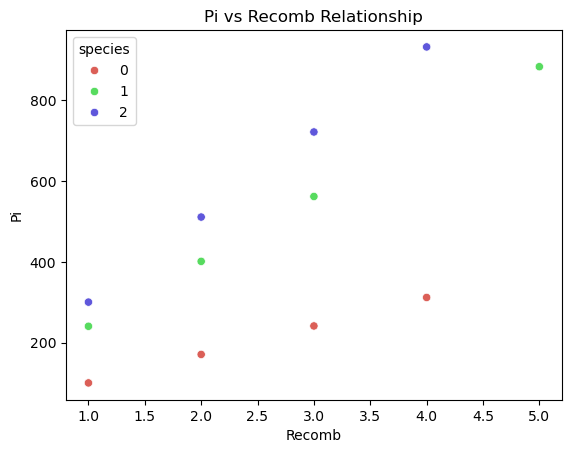

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a color palette
palette = sns.color_palette("hls", len(df['species'].unique()))

# Create the scatter plot
sns.scatterplot(x='recomb', y='pi', hue='species', data=df, palette=palette)

# Set the title and labels
plt.title('Pi vs Recomb Relationship')
plt.xlabel('Recomb')
plt.ylabel('Pi')

# Show the plot
plt.show()


In [266]:
a_01_lines = data['g0'].mean(dim=['chain', 'draw']).values[0] + data['g1'].mean(dim=['chain', 'draw']).values[0] * 100
b_01_lines = data['h0'].mean(dim=['chain', 'draw']).values[0] + data['h1'].mean(dim=['chain', 'draw']).values[0] * 100
y_01 = a_01_lines + b_0_lines * 1:5

a_02_lines = data['g0'].mean(dim=['chain', 'draw']).values[0] + data['g1'].mean(dim=['chain', 'draw']).values[0] * 300
b_02_lines = data['h0'].mean(dim=['chain', 'draw']).values[0] + data['h1'].mean(dim=['chain', 'draw']).values[0] * 300
y_02 = a_02_lines + b_02_lines * 1:5

a_10_lines = data['g0'].mean(dim=['chain', 'draw']).values[1] + data['g1'].mean(dim=['chain', 'draw']).values[1] * 200
b_10_lines = data['h0'].mean(dim=['chain', 'draw']).values[1] + data['h1'].mean(dim=['chain', 'draw']).values[1] * 200
y_10 = a_10_lines + b_10_lines * 1:5





SyntaxError: invalid syntax (2142034872.py, line 3)

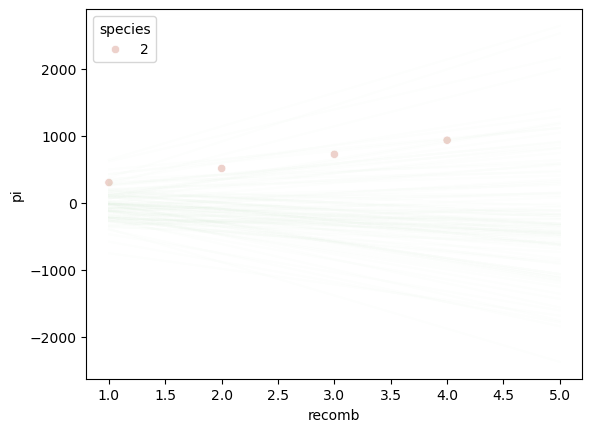

In [282]:
import numpy as np

# Define the number of samples
n_samples = 100

# Define the recombination rate range
recomb_rate = np.arange(1, 6)

# Initialize a figure
fig, ax = plt.subplots()

# Loop over each specis
    # Sample 'n_samples' random indices from the draws
random_draws = np.random.choice(data['draw'], size=n_samples)
# Calculate 'a' and 'b' for each sample
a_lines_00 = data['g0'].isel(chain=0, draw=random_draws, group=0).values + data['g1'].isel(chain=0, draw=random_draws, group=0).values * 100
    
b_lines_00 = data['h0'].isel(chain=0, draw=random_draws, group=0).values + data['h1'].isel(chain=0, draw=random_draws, group=0).values * 100


a_lines_01 = data['g0'].isel(chain=0, draw=random_draws, group=0).values + data['g1'].isel(chain=0, draw=random_draws, group=0).values * 300
    
b_lines_01 = data['h0'].isel(chain=0, draw=random_draws, group=0).values + data['h1'].isel(chain=0, draw=random_draws, group=0).values * 300


a_lines_10 = data['g0'].isel(chain=0, draw=random_draws, group=1).values + data['g1'].isel(chain=0, draw=random_draws, group=1).values * 200
    
b_lines_10 = data['h0'].isel(chain=0, draw=random_draws, group=1).values + data['h1'].isel(chain=0, draw=random_draws, group=1).values * 200



   # Calculate 'y' for each sample and add the lines to the plot
for j in range(n_samples):
    #y00 = a_lines_00[j] + b_lines_00[j] * recomb_rate
    #y01 = a_lines_01[j] + b_lines_01[j] * recomb_rate
    y10 = a_lines_10[j] + b_lines_10[j] * recomb_rate
        
    #ax.plot(recomb_rate, y00, color=palette[i], alpha=0.01)
    #ax.plot(recomb_rate, y01, color=palette[i], alpha=0.01)
    ax.plot(recomb_rate, y10, color=palette[i], alpha=0.01)



# Add the scatter plot
sns.scatterplot(x='recomb', y='pi', hue='species', data=df[df['species'] == 2])

# Show the plot
plt.show()


# Only intercept


In [ ]:
# Simulated data
np.random.seed(10)  # For reproducibility
true_g0 = np.array([0.1, 0.2])  # for 'pg1' and 'pg2'
true_g1 = np.array([0.3, 0.4])  # for 'pg1' and 'pg2'
true_h0 = np.array([0.5, 0.6])  # for 'pg1' and 'pg2'
true_h1 = np.array([0.7, 0.8])  # for 'pg1' and 'pg2'

# Create a dataframe
df = pd.DataFrame({
    'species': [0,0,0,0,1,1,1,1,2,2,2,2],
    'recomb': [1, 2, 3, 4, 5, 1, 2, 3, 4, 1, 2, 3],
    'ne': [100,100,100,100,200,200,200,200,300,300,300,300],
    'pg': [0,0,0,0,1,1,1,1,0,0,0,0],
})

# Convert categorical variables to numerical indices
group_idx, groups = pd.factorize(df["pg"], sort=True)
species_idx, species = pd.factorize(df["species"], sort=True)

# Calculate 'a' and 'b' using the true values and 'ne'
df['a_values'] = true_g0[group_idx] + true_g1[group_idx] * df['ne']
df['b_values'] = true_h0[group_idx] + true_h1[group_idx] * df['ne']


# Calculate 'pi' using 'a', 'b' and 'recomb'
df['pi'] = df['a_values'] + df['b_values'] * df['recomb']  # add some noise

# Define the model

coords = {
    "group": groups,
    "obs_id": np.arange(df['pi'].shape[0]),
    "Species": species,# Use unique species
}


model = pm.Model(coords=coords)

Ne_log = pd.DataFrame([df['species'], df['ne']]).transpose().drop_duplicates()

with model:
    recomb = pm.ConstantData('recomb', df['recomb'], dims = 'obs_id')
    pi = pm.ConstantData('pi', df['pi'], dims = 'obs_id')
    sp = pm.ConstantData('sp',species_idx, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne_log['ne'], dims = 'Species')
    pg = pm.ConstantData('pg', group_idx, dims = 'obs_id')
    
    # Hyperpriors
    g0 = pm.Normal("g0", mu=0, sigma=1, dims="group")
    g1 = pm.Normal("g1", mu=0, sigma=1, dims="group")
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    # Linear models
    mu_a = g0[group_idx] + g1[group_idx] * df['ne']
    mu_b = h0 + h1 * df['ne']

    a_offset = pm.Normal('a_offset', mu=0, sigma=0.01, dims='Species')
    b_offset = pm.Normal('b_offset', mu=0, sigma=0.01, dims='Species')

    a = pm.Deterministic("a", mu_a + a_offset[species_idx], dims='obs_id')
    b = pm.Deterministic("b", mu_b + b_offset[species_idx],  dims='obs_id')

    # Expected value
    y = a[species_idx] + b[species_idx] * df['recomb']

    # Model error
    sigma = pm.Exponential("sigma", 0.01)

    # Likelihood
    pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=df['pi'], dims="obs_id")

# Sample from the posterior distribution
    idata = pm.sample(draws=4000, tune=2000, chains=4, return_inferencedata=True, target_accept=0.99)

print(idata)
